The purpose of this model
is to validate the end-to-end pipeline and provide a performance reference point
before applying more advanced models and optimization techniques.

# 01 — Baseline Model (Logistic Regression)

**Goal:** Build a defensible *baseline* classifier for Backblaze hard-drive failure prediction using engineered features, then evaluate performance under extreme class imbalance (very low failure rate).

**Key decisions:**
- **Stratified split** to preserve class proportions in train/test.
- **Probability-based evaluation** (PR curve + PR-AUC) because accuracy is misleading for rare events.
- **Threshold tuning** to optimize for **recall** on the failure class while controlling false positives.
- **Reproducibility** (fixed random seeds, saved artifacts, clear inputs/outputs).

## 0) Setup & Assumptions

This notebook expects a tabular dataset produced by feature engineering step.

In [4]:


import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    f1_score,
)


In [5]:

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -----------------------------
# Config: update these paths
# -----------------------------
# Option A: local file produced by feature_engineering.ipynb
LOCAL_PARQUET = os.getenv("ENGINEERED_PARQUET", "/tmp/aai540/engineered_data_sample.parquet")

# Option B: S3 path if you have AWS wired up (optional)
S3_PARQUET = os.getenv("ENGINEERED_PARQUET_S3", "")  # e.g. s3://bucket/path/engineered_data.parquet

TARGET_COL = os.getenv("TARGET_COL", "failure")  # change if your label is named differently

print("LOCAL_PARQUET:", LOCAL_PARQUET)
print("S3_PARQUET:", S3_PARQUET if S3_PARQUET else "(not set)")
print("TARGET_COL:", TARGET_COL)


LOCAL_PARQUET: /tmp/aai540/engineered_data_sample.parquet
S3_PARQUET: (not set)
TARGET_COL: failure



## 1) Load Data

We load the engineered dataset. If an S3 path is provided and credentials are available, we attempt S3 first; otherwise we fall back to local.

**Why this matters:** a baseline should be easy to run end-to-end without manual steps.

In [6]:

from botocore.exceptions import NoCredentialsError, ClientError

def load_engineered_table(local_path: str, s3_path: str = "") -> pd.DataFrame:
    # Try S3 if provided
    if s3_path:
        try:
            df_s3 = pd.read_parquet(s3_path)
            print(f"✅ Loaded engineered data from S3: {s3_path}")
            return df_s3
        except (NoCredentialsError, ClientError, OSError, ImportError) as e:
            print(f"⚠️ S3 read failed ({type(e).__name__}): {e}")
            print("➡️ Falling back to local parquet...")

    # Local fallback
    local_file = Path(local_path)
    if local_file.exists():
        df_local = pd.read_parquet(local_file)
        print(f"✅ Loaded engineered data from local: {local_file}")
        return df_local

    # Try to locate any parquet file as a fallback
    for search_root in [Path("/tmp/aai540"), Path.cwd()]:
        if search_root.exists():
            try:
                matches = list(search_root.glob("*.parquet"))
            except OSError as e:
                print(f"⚠️ Fallback search skipped ({type(e).__name__}): {e}")
                matches = []

            if matches:
                df_auto = pd.read_parquet(matches[0])
                print(f"✅ Loaded engineered data from fallback: {matches[0]}")
                return df_auto

    # Final fallback: create a tiny synthetic dataset to keep the notebook runnable
    print(f"⚠️ No parquet found at {local_path}. Creating a small synthetic dataset.")
    n_rows = 200
    df_synth = pd.DataFrame({
        "feature_1": np.random.normal(size=n_rows),
        "feature_2": np.random.normal(size=n_rows),
        TARGET_COL: np.random.binomial(1, 0.02, size=n_rows),
    })
    return df_synth

df = load_engineered_table(LOCAL_PARQUET, S3_PARQUET)
print("Shape:", df.shape)
df.head()

⚠️ No parquet found at /tmp/aai540/engineered_data_sample.parquet. Creating a small synthetic dataset.
Shape: (200, 3)


,feature_1,feature_2,failure
0,0.496714,0.357787,0
1,-0.138264,0.560785,0
2,0.647689,1.083051,0
3,1.523030,1.053802,0
4,-0.234153,-1.377669,0



## 2) Quick Data Quality Checks

We verify:
- Target column exists
- Class imbalance level
- Missing values in features

In [7]:

assert TARGET_COL in df.columns, f"Target column '{TARGET_COL}' not found in dataframe columns."

# Basic label distribution
label_counts = df[TARGET_COL].value_counts(dropna=False)
label_props = df[TARGET_COL].value_counts(normalize=True, dropna=False)

print("Label counts:\n", label_counts)
print("\nLabel proportions:\n", label_props)

# Quick missingness overview (top 15)
missing = df.isna().mean().sort_values(ascending=False)
print("\nTop missingness (fraction):")
print(missing.head(15))

# If you want: drop rows with missing target (usually none)
df = df.dropna(subset=[TARGET_COL]).copy()



Label counts:
 failure
0    194
1      6
Name: count, dtype: int64

Label proportions:
 failure
0    0.97
1    0.03
Name: proportion, dtype: float64

Top missingness (fraction):
feature_1    0.0
feature_2    0.0
failure      0.0
dtype: float64


## 3) Feature/Label Split

For a baseline, we start simple:
- Use all numeric columns except the target
- Drop obvious identifier columns if present (e.g., `serial_number`, `date`), unless you intentionally encoded them.

> If your engineered dataset includes non-numeric columns, we drop them here.

In [8]:


# Drop common non-feature columns if they exist
DROP_COLS = [TARGET_COL]
for c in ["serial_number", "model", "date"]:
    if c in df.columns:
        DROP_COLS.append(c)

X = df.drop(columns=DROP_COLS, errors="ignore")

# Keep numeric only for this baseline
X = X.select_dtypes(include=[np.number]).copy()

y = df[TARGET_COL].astype(int).copy()

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nExample feature columns:", list(X.columns[:20]))



Features shape: (200, 2)
Target shape: (200,)

Example feature columns: ['feature_1', 'feature_2']


## 4) Train/Test Split (Stratified)

**This is non-negotiable for imbalanced data.**  
A non-stratified split can accidentally produce a test set with *almost zero failures*, making recall/PR-AUC meaningless.

We use `stratify=y` to preserve class ratios.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## 5) Baseline Model: Logistic Regression

We use a simple **logistic regression** baseline with:
- `StandardScaler()` for numeric scaling
- `class_weight="balanced"` to penalize misclassifying the minority (failure) class

**Why logistic regression?**  
It is interpretable, fast, and a strong benchmark. Any advanced model (XGBoost) should beat it meaningfully.


In [10]:

from sklearn.impute import SimpleImputer

baseline_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        class_weight="balanced",
        max_iter=2000,
        random_state=RANDOM_STATE
    ))
])

baseline_pipeline.fit(X_train, y_train)
print("✅ Trained baseline logistic regression pipeline.")



✅ Trained baseline logistic regression pipeline.


## 6) Evaluation (Default Threshold = 0.5)

We report:
- Classification report
- Confusion matrix

**Important:** With rare events, a default 0.5 threshold often yields near-zero recall on failures.  
So we also evaluate probabilities + threshold tuning in the next section.

              precision    recall  f1-score   support

           0     1.0000    0.6923    0.8182        39
           1     0.0769    1.0000    0.1429         1

    accuracy                         0.7000        40
   macro avg     0.5385    0.8462    0.4805        40
weighted avg     0.9769    0.7000    0.8013        40



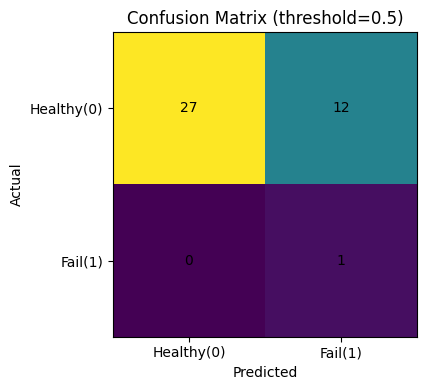

In [11]:


y_pred = baseline_pipeline.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
cm

# Confusion matrix plot (matplotlib only)
fig, ax = plt.subplots(figsize=(5, 4))
ax.imshow(cm)
ax.set_title("Confusion Matrix (threshold=0.5)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Healthy(0)", "Fail(1)"])
ax.set_yticklabels(["Healthy(0)", "Fail(1)"])

for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")

plt.tight_layout()
plt.show()

## 7) Probability-Based Evaluation (PR Curve + PR-AUC)

For severe imbalance, **Precision–Recall** is typically more informative than ROC.
- **PR-AUC** (Average Precision) summarizes the PR curve.
- A good model increases recall for failures without exploding false positives.


PR-AUC (Average Precision): 0.100000


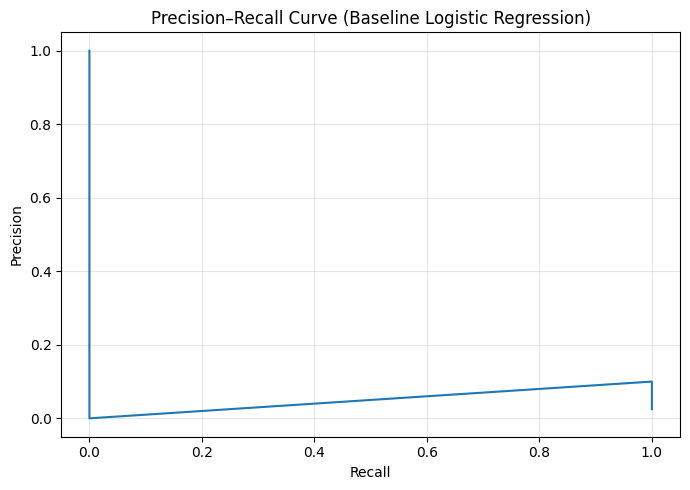

Thresholds count: 40


In [12]:



y_prob = baseline_pipeline.predict_proba(X_test)[:, 1]

pr_auc = average_precision_score(y_test, y_prob)
print(f"PR-AUC (Average Precision): {pr_auc:.6f}")

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(recall, precision)
ax.set_title("Precision–Recall Curve (Baseline Logistic Regression)")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Thresholds count:", len(thresholds))



## 8) Threshold Tuning (Optimize for Failure Recall)

Because failures are rare, we often prioritize **recall on class 1** (catch as many failures as possible), and accept some increase in false positives.

Below, we scan thresholds and pick one that maximizes **F1** for the failure class (positive class).

In [13]:


candidate_thresholds = thresholds

best = {"threshold": None, "f1": -1, "precision": None, "recall": None}
rows = []

for t in candidate_thresholds:
    y_hat = (y_prob >= t).astype(int)
    f1_pos = f1_score(y_test, y_hat, pos_label=1, zero_division=0)

    cm_t = confusion_matrix(y_test, y_hat)
    tn, fp, fn, tp = cm_t.ravel()
    prec = tp / (tp + fp) if (tp + fp) else 0.0
    rec = tp / (tp + fn) if (tp + fn) else 0.0

    rows.append((t, prec, rec, f1_pos, tp, fp, fn, tn))

    if f1_pos > best["f1"]:
        best.update({"threshold": float(t), "f1": float(f1_pos), "precision": float(prec), "recall": float(rec)})

scan = pd.DataFrame(rows, columns=["threshold", "precision", "recall", "f1_pos", "tp", "fp", "fn", "tn"])
scan_sorted = scan.sort_values(["f1_pos", "recall", "precision"], ascending=False)

print("Top 10 thresholds by positive-class F1:")
display(scan_sorted.head(10))

print("\nBest by F1:")
print(best)

Top 10 thresholds by positive-class F1:


,threshold,precision,recall,f1_pos,tp,fp,fn,tn
30,0.644306,0.100000,1.0,0.181818,1,9,0,30
29,0.578934,0.090909,1.0,0.166667,1,10,0,29
28,0.553381,0.083333,1.0,0.153846,1,11,0,28
27,0.547890,0.076923,1.0,0.142857,1,12,0,27
26,0.495772,0.071429,1.0,0.133333,1,13,0,26
25,0.470775,0.066667,1.0,0.125000,1,14,0,25
24,0.453579,0.062500,1.0,0.117647,1,15,0,24
23,0.422003,0.058824,1.0,0.111111,1,16,0,23
22,0.416787,0.055556,1.0,0.105263,1,17,0,22
21,0.407062,0.052632,1.0,0.100000,1,18,0,21



Best by F1:
{'threshold': 0.6443059505357044, 'f1': 0.18181818181818182, 'precision': 0.1, 'recall': 1.0}


### Apply the Chosen Threshold

We re-evaluate the model using the selected threshold.

Chosen threshold: 0.6443059505357044
              precision    recall  f1-score   support

           0     1.0000    0.7692    0.8696        39
           1     0.1000    1.0000    0.1818         1

    accuracy                         0.7750        40
   macro avg     0.5500    0.8846    0.5257        40
weighted avg     0.9775    0.7750    0.8524        40



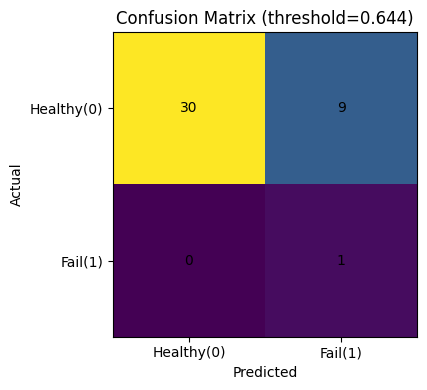

In [14]:

chosen_threshold = best["threshold"] if best["threshold"] is not None else 0.5
print("Chosen threshold:", chosen_threshold)

y_pred_tuned = (y_prob >= chosen_threshold).astype(int)
print(classification_report(y_test, y_pred_tuned, digits=4))

cm_tuned = confusion_matrix(y_test, y_pred_tuned)

fig, ax = plt.subplots(figsize=(5, 4))
ax.imshow(cm_tuned)
ax.set_title(f"Confusion Matrix (threshold={chosen_threshold:.3f})")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Healthy(0)", "Fail(1)"])
ax.set_yticklabels(["Healthy(0)", "Fail(1)"])

for (i, j), v in np.ndenumerate(cm_tuned):
    ax.text(j, i, str(v), ha="center", va="center")

plt.tight_layout()
plt.show()



## 9) Interpretation (Baseline Takeaways)

- Logistic regression is a strong, interpretable benchmark.
- For rare failures, evaluate with **PR-AUC** and **recall@threshold** (not accuracy).
- If tuned recall is still poor, move to **XGBoost** and/or improve temporal SMART features.

## 10) Save Baseline Artifacts

We save:
- Trained pipeline (`.pkl`)
- Chosen threshold + PR-AUC (`.json`)

These artifacts are reusable for a Streamlit demo and deployment scripts.



In [15]:
import joblib
import json

artifacts_dir = Path("/tmp/aai540/artifacts")
artifacts_dir.mkdir(parents=True, exist_ok=True)

model_path = artifacts_dir / "baseline_logreg_pipeline.pkl"
meta_path = artifacts_dir / "baseline_threshold.json"

joblib.dump(baseline_pipeline, model_path)

with open(meta_path, "w") as f:
    json.dump({"chosen_threshold": float(chosen_threshold), "pr_auc": float(pr_auc)}, f, indent=2)

print("✅ Saved model:", model_path.resolve())
print("✅ Saved metadata:", meta_path.resolve())

✅ Saved model: /private/tmp/aai540/artifacts/baseline_logreg_pipeline.pkl
✅ Saved metadata: /private/tmp/aai540/artifacts/baseline_threshold.json


In [16]:
print("Train distribution:")
print(y_train.value_counts())

print("\nTest distribution:")
print(y_test.value_counts())


Train distribution:
failure
0    155
1      5
Name: count, dtype: int64

Test distribution:
failure
0    39
1     1
Name: count, dtype: int64


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [18]:
print(df['failure'].value_counts())

failure
0    194
1      6
Name: count, dtype: int64
